In [1]:
# Restructure of project into functions + model adjustment
    # Function scope with True/False flags
    # ML model layer refinement & training
    # Parsing of 1hr raw data into 4 consecutive 15m l2update segements    

In [2]:
# Imports
import pandas as pd
import numpy as np
import requests
import json
from json import loads
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import time
import msgpack

# Charting-specific imports (matplotlib, matplotlib.finance)
import matplotlib.finance
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
#from matplotlib.finance import volume_overlay, volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
    # https://matplotlib.org/api/finance_api.html#module-matplotlib.finance
import matplotlib.patheffects as PathEffects
    # [plt.text object].set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    # plt.text reference: https://matplotlib.org/api/text_api.html#matplotlib.text.Text

# API-specific imports (local install required; do NOT use default pip install)
import gdax
    # Python setup.py install with environment activated to install/use
    # Install locally with 'python setup.py install' & development branch of gdax-python checked out
    # Do not use default gdax pip install package - that version of the package is currently broken
        # Default pip install has broken mongo connection and websocket connection close() error
        # Development branch of gdax-python has merged pull requests that fix those issues

# Pymongo import (connection to local client DB)
import pymongo
from pymongo import MongoClient

# Preprocessing imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.models import model_from_json
from keras import backend as K
from keras import optimizers
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

# Auto Support and Resistance/autoSR() import requirements
from sklearn.cluster import MeanShift, estimate_bandwidth
from pandas_datareader import data, wb

C:\Users\tyu-dev\Anaconda3\envs\pythondata\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\tyu-dev\Anaconda3\envs\pythondata\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
###########################################################################    
#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)
###########################################################################

### Force Keras/TF to use CPU backend when GPU present by setting device_count (above) to:
    # {'CPU' : 1, 'GPU' : 0}

# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib

# Verify GPU availability for tensorflow backend
print(device_lib.list_local_devices())
print("==============================================")
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 106480632691628515
]
[]


In [4]:
# Global variables

# Boolean to drop existing mongo collection/scrape upon scrape() init
dropFlag = False

# Boolean to set size_delta to l2update values for first update to snapshot
    # Inital value = False
firstUpdate_both = False

# Value to track if feature_creation_inital() was run
    # Inital value = False
inital_feature_run = False

In [5]:
# Connection establishment

# Establish connection to GDAX public endpoint
public_client = gdax.PublicClient()

# Mongo database and collection specification:
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client.btcusd_db
btcusd_collection = db.btcusd_collection

In [6]:
# Function to start scrape process from websocket to mongodb instance
def scrape_start():
    
    # Drop existing collection from db if dropFlag == True (on new scrape):
    if 'btcusd_db' in mongo_client.database_names() and dropFlag is True:
        mongo_client['btcusd_db'].drop_collection('btcusd_collection')
        #print(mongo_client.database_names())
        #print(db.collection_names())
        
    # Start instance of websocket client for L2 Orderbook + L2 update data request and scrape
    wsClient = gdax.WebsocketClient(url="wss://ws-feed.gdax.com", 
                                products=["BTC-USD"],\
                                message_type="subscribe",\
                                channels =["level2"],\
                                mongo_collection=btcusd_collection,\
                                should_print=False)
    
    # Save request open time and start websocket
    time.sleep(4)
    request_time_start=public_client.get_time()
    wsClient.start()
    
    # scrape_time is variable for time between websocket connection start and end
        # Defined in seconds
        # i.e. 600 seconds = scrape running for 10 minutes
        # 1 hour = 3600 seconds
        # 4 hours = 14400
        # 10 hours = 18000
    scrape_time = 600
    time.sleep(scrape_time)
    # Save request close time and close websocket
    request_time_end=public_client.get_time()
    wsClient.close()
    
    # Append request times for open/close of websocket stream to dataframe, save to csv
    request_log_df = pd.DataFrame.from_dict({'request start':request_time_start,'request end':request_time_end},orient ='index')
    request_log_df.to_csv("raw_data/request_log.csv",header=True,encoding='utf-8',index =True)

# Function to load and parse data from Mongo into dataframes
def load_parse():
    
    #Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot/orderbook state response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format 
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df= pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to csv (API -> Mongo -> Dataframe -> .csv)
        # Save data to .csv format in raw_data folder
    l2update_formatted.to_csv("raw_data/l2update.csv",header=True,encoding='utf-8',index =False)
    snapshot_asks_df.to_csv("raw_data/snapshot_asks.csv",header=True,encoding='utf-8',index =False)
    snapshot_bids_df.to_csv("raw_data/snapshot_bids.csv",header=True,encoding='utf-8',index =False)

In [8]:
# Function to load and parse data from Mongo into dataframes
def load_parse_msgpack():
    
    #Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot/orderbook state response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format 
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df= pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to pandas-messagepack format (API -> Mongo -> Dataframe -> .msg)
        # Save data to .msg format in raw_data folder
    
    l2update_formatted.to_msgpack("raw_data_10h/l2update_10h.msg",encoding='utf-8')
    snapshot_asks_df.to_msgpack("raw_data_10h/snapshot_asks_10h.msg",encoding='utf-8')
    snapshot_bids_df.to_msgpack("raw_data_10h/snapshot_bids_10h.msg",encoding='utf-8')

In [9]:
# Function to read in raw data from csv, 'raw_data' folder
    # 'raw_data' folder has 1hr of scraped data (snapshot + l2 response updates)
    # 'test_data' folder only has 10 minutes of scraped data 
    
def raw_csv_load():
    global request_log_df
    global snapshot_asks_df
    global snapshot_bids_df
    global l2update_df
    
    global l2update_15min_1
    global l2update_15min_2
    global l2update_15min_3
    global l2update_15min_4
  
    snapshot_asks_df = pd.read_csv("raw_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    snapshot_bids_df = pd.read_csv("raw_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    l2update_df = pd.read_csv("raw_data/l2update.csv", dtype ={'size':float})
    request_log_df= pd.read_csv("raw_data/request_log.csv")
    
    #l2update_df (1 hour of data) split into 4 15-min dataframes/csvs
    l2update_15min_1 = pd.read_csv("raw_data/l2update_15min_1.csv",dtype ={'size':float})
    l2update_15min_2 = pd.read_csv("raw_data/l2update_15min_2.csv",dtype ={'size':float})
    l2update_15min_3 = pd.read_csv("raw_data/l2update_15min_3.csv",dtype ={'size':float})
    l2update_15min_4 = pd.read_csv("raw_data/l2update_15min_4.csv",dtype ={'size':float})


In [10]:
def raw_data_load_msgpack():
    global request_log_df
    global snapshot_asks_df
    global snapshot_bids_df
    global l2update_df
    
    global l2update_15min_1
    global l2update_15min_2
    global l2update_15min_3
    global l2update_15min_4
  
    snapshot_asks_df = pd.read_msgpack("raw_data_10h/snapshot_asks_10h.msg")
    snapshot_bids_df = pd.read_msgpack("raw_data_10h/snapshot_bids_10h.msg")
    l2update_df = pd.read_msgpack("raw_data_10h/l2update_10h.msg")
    request_log_df= pd.read_csv("raw_data_10h/request_log_10h.csv")
    
    #l2update_df (1 hour of data) split into 4 15-min dataframes/csvs
    #l2update_15min_1 = pd.read_msgpack("raw_data_10h/l2update_15min_1.csv",dtype ={'size':float})
    #l2update_15min_2 = pd.read_msgpack("raw_data_10h/l2update_15min_2.csv",dtype ={'size':float})
    #l2update_15min_3 = pd.read_msgpack("raw_data_10h/l2update_15min_3.csv",dtype ={'size':float})
    #l2update_15min_4 = pd.read_msgpack("raw_data_10h/l2update_15min_4.csv",dtype ={'size':float})

In [11]:
# Function that requests 15min of chart data from GDAX API 
    # Start and end time can be specified, but must be in ISO 8601 format
    
def chart_15m_request(request_log_df):
    
    global chart_15m_df
    request_start = request_log_df['iso'][1]
    request_end = request_log_df['iso'][0]

    # Request 15 minutes of candlestick (open high low close) data from API
        # start time must be in ISO 8601 format for get_product_historic_rates()
    chart_15m = public_client.get_product_historic_rates('BTC-USD', start = request_start, granularity=60)

    # Convert chart data response into dataframes
    chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

    # Reorder columns according to label order required by matplotlib finance package
    chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

    # Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
    chart_15m_df.sort_values(by='time',axis=0, inplace =True)

    #Convert/sort time to datetime object (for matplotlib chart format requirement)
    chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')

In [12]:
#from sklearn.cluster import MeanShift, estimate_bandwidth
#estimate_bandwidth()
#MeanShift()

In [13]:
# Auto support/resistance adapted into function 
    # Using estimate_bandwidth and meanshift() from sklearn.cluster library
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
    # Takes dataframe object with open/high/low/close values 
        # Returns list of auto-generated support and resistance levels for price action
        
def autoSR(dataframe):
    
    global ml_results_modified
    
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            # Remove duplicate S/R level values
            # Using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()

    # Convert to int and remove duplicates (including duplicates from truncation):    
    # Convert ml_results into sorted int array
    ml_results_modified =np.asarray(ml_results)
    ml_results_modified =np.trunc(ml_results_modified).astype(int)
    ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
    # Remove duplicates from int conversion
    ml_results_modified_set=set(ml_results_modified)
    ml_results_modified = list(ml_results_modified_set)
    ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort')
    ml_results_modified
            
    return ml_results_modified

In [14]:
# Function to generate candlestick chart from candlestick data (API request)
    # Calls autoSR() inside function to also plot support/resistance lines
    
def generate_chart(dataframe):

    dataframe = chart_15m_df 
    
    matplotlib.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(20, 14))
    
    # Generate chart of past 15 minutes with autogenerated support and resistance levels:
    candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],\
                      chart_15m_df['low'],chart_15m_df['close'],width=2,\
                      colorup='k',colordown='r',alpha=.5)
    
    ax.set_xticklabels(chart_15m_df['time'] ,rotation=30,ha="right")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(17))
        # n + 2 for proper label set at 20,18/20,14 chart size
    plt.yticks(np.arange(int(min(chart_15m_df['low'])-10), max(chart_15m_df['high'])+10, 10))
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    #ax.minorticks_on()
    ax.set_axisbelow(True)
    #fig.set_zorder(0)
    #ax.set_zorder(1)
    ax.tick_params(axis='y', pad=10)
    ax.grid(which='major', linestyle='--', linewidth='0.2', color='b')
    matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
    
    # call autoSR() to autogenerate support and resistance levels from chart data
    ml_results_modified = autoSR(chart_15m_df)
    
    # Add S/R labels to chart
        # count increment is used for staggering of labels in conjunction with modulus   
    count = 1
    for k in ml_results_modified:
        # Plot each S/R level as horizontal line on chart
        ax.axhline(y=k)
        if count%3 == 0:
            plt.text(y=k,s=k,x=count-5,color='blue',rotation=45,size ='large')\
            .set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if count%3 == 1:
            plt.text(y=k,s=k,x=count+5,color='blue',rotation=45,size ='large')\
            .set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if count%3 == 2:
            plt.text(y=k,s=k,x=count+16,color='blue',rotation=45, size ='large')\
            .set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        count = count +1 
    plt.savefig('saved_charts/chart_15m_generated.png')    
    #plt.tight_layout()
    return plt.show()

In [15]:
# Function to create and set inital/placeholder values
    # size_delta, position, sr_prox_value, sr_prox_line, is_line
    
def feature_creation_inital():
    global inital_feature_run
    
    if inital_feature_run == False:
           
        # Set inital size delta l2 snapshot - use decimal point to force as float
        snapshot_asks_df['size_delta'] = 0.0
        snapshot_bids_df['size_delta'] = 0.0

        # Set inital position for l2 snapshot
        snapshot_asks_df['position'] = snapshot_asks_df.index +1
        snapshot_bids_df['position'] = snapshot_bids_df.index +1

        # Reverse index for sell/asks
        # snapshot_asks_df =snapshot_asks_df[::-1]
        # Reverse inital position indicator for bids/buy side
        rev = snapshot_bids_df['position'].values * -1
        snapshot_bids_df['position'] = rev

        # Set inital proximity value and inital value for nearest prox line
        snapshot_asks_df['sr_prox_value'] = 0
        snapshot_asks_df['sr_prox_line'] = 0
        snapshot_bids_df['sr_prox_value'] = 0
        snapshot_bids_df['sr_prox_line'] = 0
        
        # Create flag/boolean column for is_line feature - key prediction value for model
        snapshot_asks_df['is_line'] = 0
        snapshot_bids_df['is_line'] = 0
        
        # Set feature_creation_inital_run flag to True once run
        feature_creation_inital_run = True
        print("run")   
        
    elif inital_feature_run == True:
        # Required syntax for logical operator/ if-else structure, but does nothing as a result
        # i.e., a "pass"
        print("pass")
        pass

In [16]:
# Seperation of l2_updates into 4 15-min seperate l2 updates
    #l2update_df (1 hour of data) split into 4 15-min dataframes/csvs
    # Each individual l2update_15min segment can be applied to the snapshot state 
        # To represent the orderbook at 4 distinct points in time + feature updates
        
def l2update_1hr_split(l2update_df):
    
    global l2update_15min_1
    global l2update_15min_2
    global l2update_15min_3
    global l2update_15min_4
    
    global l2update_time_df
    
    # Total number of samples/rows in l2update_df (1hr of data):
        # 193848/4 = 48462 
            # 48462
            # 96924
            # 145386
            # 193848
    l2update_15min_1=l2update_df[:48462]
    l2update_15min_2=l2update_df[48462:96924]
    l2update_15min_3=l2update_df[96924:145386]
    l2update_15min_4=l2update_df[145386:193848]
    l2update_15min_1.to_csv("raw_data/l2update_15min_1.csv",header=True,encoding='utf-8',index =False)
    l2update_15min_2.to_csv("raw_data/l2update_15min_2.csv",header=True,encoding='utf-8',index =False)
    l2update_15min_3.to_csv("raw_data/l2update_15min_3.csv",header=True,encoding='utf-8',index =False)
    l2update_15min_4.to_csv("raw_data/l2update_15min_4.csv",header=True,encoding='utf-8',index =False)
    
    # Add l2update_15min segement iso times to dataframe
        # Create dataframe with start time of every l2update segement
    time.sleep(0.5)
    l2update_15min_1.reset_index(inplace=True,drop = True)
    l2update_15min_2.reset_index(inplace=True,drop = True)
    l2update_15min_3.reset_index(inplace=True,drop = True)
    l2update_15min_4.reset_index(inplace=True,drop = True)
    time.sleep(0.5)
    l2update_time_df=pd.DataFrame.from_dict(data={"l2update_15min_1":l2update_15min_1['time'][0],
                                "l2update_15min_2":l2update_15min_2['time'][0],
                                "l2update_15min_3":l2update_15min_3['time'][0],
                                "l2update_15min_4":l2update_15min_4['time'][0]},orient='index')

    # Change time label to iso for chart generation function
        # predicted vs actual for each 15 min section of L2 update 
            # New 15min chart request + autoSR() request for each of the l2update_15min segments
            # Not fully implemented/working 
    l2update_time_df.columns = ["iso"]


In [17]:
#Function to join both sides of orderbook together into one dataframe
    # Buy/sell side labels need to be kept if combining 
    # Or use positive/negative values from position to determine side labels from model output
    
def snapshot_join(snapshot_asks_df,snapshot_bids_df):
    global snapshot_both_df
    snapshot_both_df = pd.concat([snapshot_asks_df,snapshot_bids_df], axis=0, 
                                join='outer', join_axes=None, ignore_index=False,
                                keys=None, levels=None, names=None, 
                                verify_integrity=False, copy=True)

In [18]:
# Function to update orderbook states and feature values 
    # Inputs (snapshot_both_df,l2update_15min)
        # Combined ask/sell snapshot required for this function + l2update state dataframe  
    # Ideally applied to snapshot over defined interval (15m, in sync with chart update)
        # Removals: Orders with a 'size' of 0 are removed from the orderbook
        # Feature updates: size_delta, position, sr_prox_value, sr_prox_line, is_line  
    # Must be run before model input in sequence
    
def apply_l2_update(snapshot_both_df,l2update_15min):
    
    global firstUpdate_both 
    
    snapshot_both_df = snapshot_both_df
    l2update_df = l2update_15min
    
    # Convert to array for loop value traversal        
    ml_results_modified_array = np.array(ml_results_modified)
    
    for i in range(len(snapshot_both_df)):

         # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_both_df['price'].values[i])
            snapshot_both_df.drop(snapshot_both_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        #elif l2update_df['size'].values[i] != 0 & firstUpdate_both == False:
            #snapshot_both_df['size_delta'].values[i] = l2update_df['size'].values[i]
            #firstUpdate_both = True
            
        #Subsequent size delta calc (if size not zero and firstUpdate_both == True):
            # Calcluate 'size_delta'
        #if l2update_df['size'].values[i] != 0 & firstUpdate_both == True:
            #currentsize =snapshot_both_df['size'].values[i] 
            #updatesize = l2update_df['size'].values[i]
            #snapshot_both_df['size_delta'].values[i] = updatesize-currentsize
            #snapshot_both_df['size'].values[i] = updatesize
            
        if l2update_df['size'].values[i] != 0:
            currentsize =snapshot_both_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_both_df['size_delta'].values[i] = updatesize-currentsize
            snapshot_both_df['size'].values[i] = updatesize
            
            
        # Update 'position' for orderbook state
        if snapshot_both_df['side'] is "buy":
            snapshot_both_df['position'] = snapshot_both_df.index + 1
            rev = snapshot_both_df['position'].values * -1
            snapshot_both_df['position'] = rev 
        elif snapshot_both_df['side'] is "sell":
            snapshot_asks_df['position'] = snapshot_asks_df.index + 1
        
        # Update 'is_line' state from ml_results_modified
        if snapshot_both_df['price'].values[i] in ml_results_modified: 
            snapshot_both_df['is_line'].values[i] = 1
    
    # Loop structure to update 'sr_prox_line','sr_prox_value' between orderbook states
    for i in range(len(snapshot_both_df['price'])):
        #if snapshot_both_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_both_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_both_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            # Set sr_prox_value to distance from closest S/R line
            snapshot_both_df['sr_prox_value'].values[i] = lowest_abs
            # Set sr_prox_line value
            snapshot_both_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]    
    

In [19]:
# Breakout print-only version of sr_prox_line & sr_prox_value loop from above 
    # Examination of output/operation (loop function and operation)
    # raw_csv_load() and snapshot_join() must be run first before this function
def breakout_sr_print():    
    for i in range(len(snapshot_both_df['price'])):
            #if snapshot_both_df['price'].values[i] in ml_results_modified: 

                priceInt = int(snapshot_both_df['price'].values[i])

                diff =abs(ml_results_modified - priceInt)
                diff_noabs =ml_results_modified - priceInt
                diff_array = np.array(diff)
                lowest_abs =min(diff)
                print("=============================")
                print("Price: ")
                print(snapshot_both_df['price'].values[i])

                print("Diff:")
                print(diff)
                print(diff_noabs)

                print("lowest_abs value: ")
                print(lowest_abs)

                minIndex= list(diff_array).index(lowest_abs)
                print("Closest S/R line:")
                print(ml_results_modified[minIndex])
                print("=============================")

                #Set sr_prox_value to distance from closest S/R line
                #snapshot_both_df['sr_prox_value'].values[i] = lowest_abs

                #Set sr_prox_line value
                #snapshot_both_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]    


In [20]:
def chart_15m_request(request_log_df):
    
    global chart_15m_df
    request_start = request_log_df['iso'][1]
    request_end = request_log_df['iso'][0]

    # Request 15 minutes of candlestick (open high low close) data from API
        # start time must be in ISO 8601 format for get_product_historic_rates()
    chart_15m = public_client.get_product_historic_rates('BTC-USD', start = request_start, granularity=60)

    # Convert chart data response into dataframes
    chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

    # Reorder columns according to label order required by matplotlib finance package
    chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

    # Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
    chart_15m_df.sort_values(by='time',axis=0, inplace =True)

    #Convert/sort time to datetime object (for matplotlib chart format requirement)
    chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')

In [21]:
###########################################################################

# Function execution order/testing 

# Load in data:
#raw_csv_load()
raw_data_load_msgpack()

snapshot_asks_df.head()

,side,price,size
0,sell,9693,0.16111052
1,sell,9693.85,0.05
2,sell,9696.6,0.1
3,sell,9699.24,0.125
4,sell,9699.25,1.02998


In [21]:
# Debugging of first OHLC 15-min data request:
request_log_df

,Unnamed: 0,iso,epoch
0,request end,2018-05-05T09:33:03.486Z,1.525513e+09
1,request start,2018-05-04T23:33:03.719Z,1.525477e+09


In [22]:
request_log_df['iso'][1]

'2018-05-04T23:33:03.719Z'

In [23]:
print(request_log_df['epoch'][1])
print(request_log_df['epoch'][0])

1525476783.7189999
1525512783.486


In [24]:
chart_15m= public_client.get_product_historic_rates('BTC-USD', start = str(request_log_df['iso'][1]),
                                                    end = str(request_log_df['iso'][0]),
                                                    granularity=60)


# Request is not fetching specified start date
    # or full request is truncated due to candlestick datapoint size
    # (Potential issue with API or pagination of request over 300 points)
    # https://docs.gdax.com/#get-historic-rates

In [25]:
# Running gdax-ohlc-import 
# bash/shell:
    # cd gdax-ohlc-import
    # python main.py -p BTC-USD -s 2018-05-04 debug_db.sqlite3

In [26]:
# Import test of scraped data from gdax-ohlc-import submodule
import sqlite3
con = sqlite3.connect('raw_data_10h/ohlc_debug_db.sqlite3')
c = con.cursor()
# Read data into pandas dataframe
sql = 'SELECT * FROM candles'
ohlc_test_df = pd.read_sql_query(sql, con, index_col='time', parse_dates={'time': 's'})

In [27]:
# Examine OHLC response from gdax-ohlc-import API request
ohlc_test_df.head()

,market,open,high,low,close,volume
time,,,,,,
2018-05-03 04:59:00,BTC-USD,9257.99,9258,9255.11,9255.11,9.985062880000003
2018-05-03 04:58:00,BTC-USD,9258.05,9258.05,9257.99,9258,4.1812499999999995
2018-05-03 04:57:00,BTC-USD,9258.05,9258.05,9258.04,9258.04,1.10298206
2018-05-03 04:56:00,BTC-USD,9258.05,9258.05,9258.04,9258.04,0.7661465500000001
2018-05-03 04:55:00,BTC-USD,9258,9258.04,9258,9258.04,2.47918213


In [28]:
ohlc_test_df.tail()

,market,open,high,low,close,volume
time,,,,,,
2018-05-11 13:04:00,BTC-USD,8531.19,8531.19,8531.19,8531.19,4.02662902
2018-05-11 13:03:00,BTC-USD,8532.19,8532.19,8531.18,8531.19,2.03358251
2018-05-11 13:02:00,BTC-USD,8542.01,8542.01,8532,8532.18,14.487937490000002
2018-05-11 13:01:00,BTC-USD,8542.01,8542.01,8542,8542.01,1.7755767900000001
2018-05-11 13:00:00,BTC-USD,8542,8542.01,8541.99,8542.01,2.9578364899999996


In [29]:
ohlc_test_df.drop('market',inplace=True, axis=1)

In [30]:
ohlc_test_df.head()

,open,high,low,close,volume
time,,,,,
2018-05-03 04:59:00,9257.99,9258,9255.11,9255.11,9.985062880000003
2018-05-03 04:58:00,9258.05,9258.05,9257.99,9258,4.1812499999999995
2018-05-03 04:57:00,9258.05,9258.05,9258.04,9258.04,1.10298206
2018-05-03 04:56:00,9258.05,9258.05,9258.04,9258.04,0.7661465500000001
2018-05-03 04:55:00,9258,9258.04,9258,9258.04,2.47918213


In [31]:
# Check request end/start from log
    # 10 hours of scraped data ('raw_data_10h' folder)
request_log_df

,Unnamed: 0,iso,epoch
0,request end,2018-05-05T09:33:03.486Z,1.525513e+09
1,request start,2018-05-04T23:33:03.719Z,1.525477e+09


In [32]:
import dateutil.parser
rs = dateutil.parser.parse(request_log_df['iso'][1])
re = dateutil.parser.parse(request_log_df['iso'][0])

In [33]:
re

datetime.datetime(2018, 5, 5, 9, 33, 3, 486000, tzinfo=tzutc())

In [34]:
print(re)

2018-05-05 09:33:03.486000+00:00


In [35]:
rs

datetime.datetime(2018, 5, 4, 23, 33, 3, 719000, tzinfo=tzutc())

In [36]:
print(rs)

2018-05-04 23:33:03.719000+00:00


In [37]:
ohlc_test_df.head()

,open,high,low,close,volume
time,,,,,
2018-05-03 04:59:00,9257.99,9258,9255.11,9255.11,9.985062880000003
2018-05-03 04:58:00,9258.05,9258.05,9257.99,9258,4.1812499999999995
2018-05-03 04:57:00,9258.05,9258.05,9258.04,9258.04,1.10298206
2018-05-03 04:56:00,9258.05,9258.05,9258.04,9258.04,0.7661465500000001
2018-05-03 04:55:00,9258,9258.04,9258,9258.04,2.47918213


In [148]:
# Request has more data than required; see tail of dataframe
ohlc_test_df.tail()

,open,high,low,close,volume
time,,,,,
2018-05-03 20:04:00,9611,9611,9601.35,9601.35,16.672840950000005
2018-05-03 20:03:00,9611.72,9611.73,9611,9611,11.006632669999998
2018-05-03 20:02:00,9613,9613,9611.72,9611.72,16.637999999999995
2018-05-03 20:01:00,9620,9620,9612.99,9613,11.820705529999996
2018-05-03 20:00:00,9623.61,9623.61,9620,9620,5.669958690000001


In [80]:
# Restrict API request to start and end time of request_log_df
#ohlc_test_df.loc[rs:re]

In [119]:
#test_df=ohlc_test_df

In [120]:
#test_df.head()

,open,high,low,close,volume
time,,,,,
2018-05-04 04:59:00,9599.99,9600,9599.99,9599.99,1.316563
2018-05-04 04:58:00,9600,9600,9599.99,9600,2.1150770499999996
2018-05-04 04:57:00,9599.99,9600,9599.99,9599.99,1.0010389800000001
2018-05-04 04:56:00,9599.99,9600,9599.99,9599.99,1.6866559799999998
2018-05-04 04:55:00,9600,9600,9599.99,9600,2.16706543


In [124]:
begin = pd.Timestamp('2018-05-04 23:33:03')
end = pd.Timestamp('2018-05-05 09:33:03')
#test_df.truncate(before=begin, after=end)

#df.set_index(['time'], inplace=True)
#test_df_subset.sort_index()
#test_df_subset= test_df.ix['2018-05-04 23:33:03':'2018-05-05 09:33:03']

In [32]:
#Examine OHLC response from gdax-python API request before parsing
chart_15m

[[1529620740, 6741.43, 6743, 6741.43, 6742.99, 1.8928],
 [1529620680, 6720.99, 6741.43, 6720.99, 6741.43, 97.89579087000004],
 [1529620620, 6710.89, 6721, 6710.9, 6720.99, 27.163497080000017],
 [1529620560, 6710.7, 6710.9, 6710.7, 6710.9, 0.2194],
 [1529620500, 6710.69, 6710.7, 6710.7, 6710.7, 0.5893999999999999],
 [1529620440, 6710.4, 6710.7, 6710.4, 6710.7, 0.8024],
 [1529620380, 6710.39, 6710.4, 6710.4, 6710.4, 0.8563999999999999],
 [1529620320, 6710.3, 6710.39, 6710.3, 6710.39, 1.363],
 [1529620260, 6710.29, 6710.3, 6710.3, 6710.3, 0.7635000000000001],
 [1529620200, 6710, 6710.3, 6710, 6710.3, 0.5771799099999999],
 [1529620140, 6707.05, 6710, 6707.05, 6709.99, 6.15187325],
 [1529620080, 6707.04, 6707.05, 6707.05, 6707.05, 0.66053242],
 [1529620020, 6707.05, 6707.05, 6707.05, 6707.05, 1.1574],
 [1529619960, 6707.04, 6707.05, 6707.05, 6707.04, 1.1878000000000002],
 [1529619900, 6707.04, 6707.05, 6707.05, 6707.04, 2.2104603500000004],
 [1529619840, 6707.04, 6707.05, 6707.04, 6707.05, 

In [33]:
# Convert chart data response into dataframes
chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

In [34]:
# Reorder columns according to label order required by matplotlib finance package
chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

In [35]:
# Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
chart_15m_df.sort_values(by='time',axis=0, inplace =True)

In [36]:
#Convert/sort time to datetime object (for matplotlib chart format requirement)
chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')

In [37]:
chart_15m_df

,time,open,high,low,close,volume
299,2018-06-21 17:40:00,6701.90,6701.90,6701.90,6701.90,0.193000
298,2018-06-21 17:41:00,6701.90,6701.90,6701.89,6701.89,1.076200
297,2018-06-21 17:42:00,6701.89,6701.90,6701.89,6701.89,0.357300
296,2018-06-21 17:43:00,6701.89,6708.74,6701.89,6708.74,4.671086
295,2018-06-21 17:44:00,6708.74,6708.75,6708.73,6708.75,3.386950
294,2018-06-21 17:45:00,6708.75,6710.99,6708.75,6710.99,1.707900
293,2018-06-21 17:46:00,6710.99,6710.99,6710.98,6710.98,1.054389
292,2018-06-21 17:47:00,6710.98,6710.99,6710.98,6710.99,0.676304
291,2018-06-21 17:48:00,6710.98,6710.99,6710.98,6710.99,2.338550
290,2018-06-21 17:49:00,6710.98,6710.98,6710.98,6710.98,1.863584


In [32]:
# Perform first candlestick data request (start datetime from request_log):
chart_15m_request(request_log_df)
chart_15m_df.head()
#chart_15m_df.tail()

,time,open,high,low,close,volume
299,2018-06-14 00:19:00,6307.00,6307.00,6307.00,6307.00,1.173700
298,2018-06-14 00:20:00,6307.00,6310.10,6306.99,6310.10,3.231673
297,2018-06-14 00:21:00,6310.10,6313.00,6310.10,6312.99,3.517727
296,2018-06-14 00:22:00,6312.99,6313.13,6312.99,6313.12,0.953400
295,2018-06-14 00:23:00,6313.13,6315.00,6313.13,6315.00,3.709118


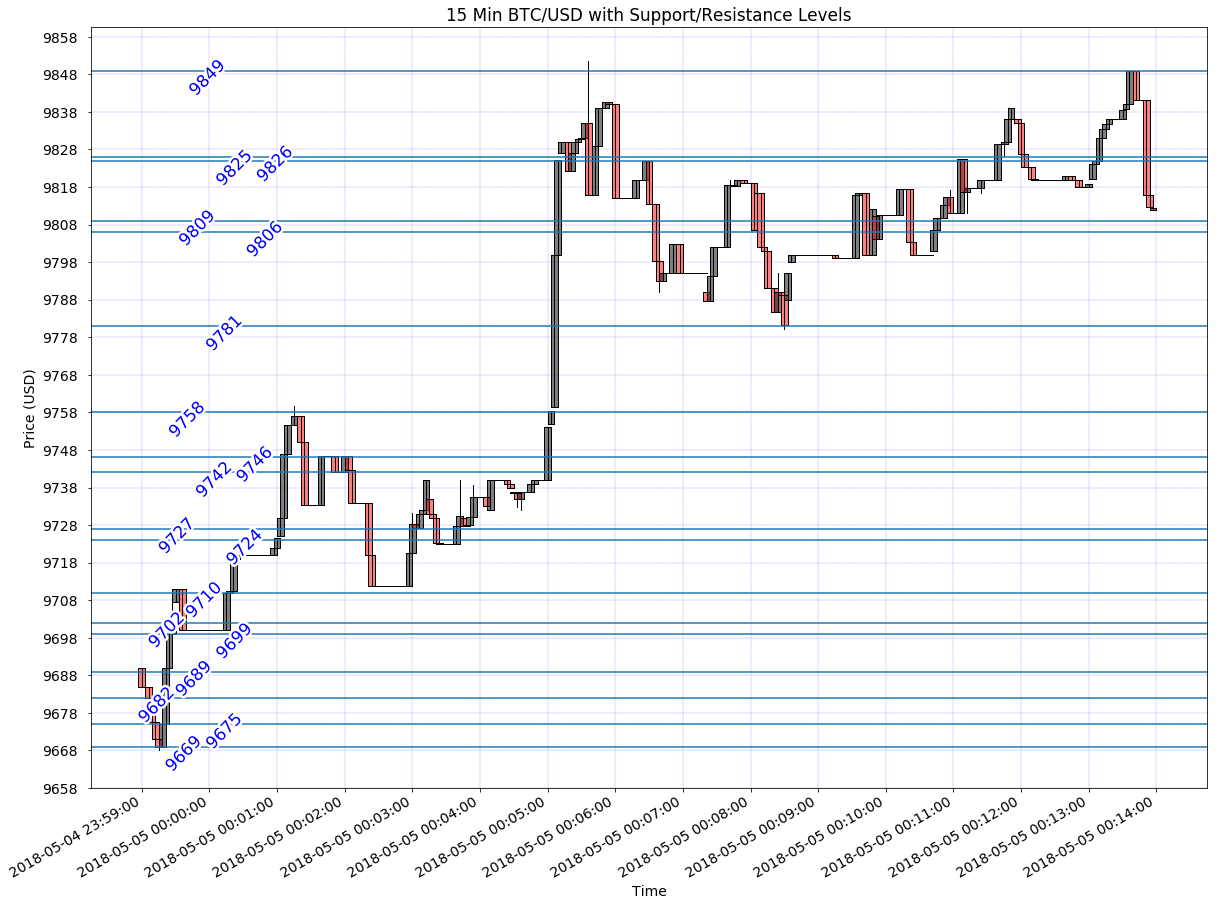

(array([9669, 9675, 9682, 9689, 9699, 9702, 9710, 9724, 9727, 9742, 9746,
        9758, 9781, 9806, 9809, 9825, 9826, 9849]), None)

In [19]:
# Plot the above data with autogenerated support and resistance levels for price 
    # Pass dataframe to autoSR() --> create chart + generate and plot auto S/R levels
    # Pass dataframe to autoSR() --> just generate S/R levels and return as array
autoSR(chart_15m_df), generate_chart(chart_15m_df)

In [20]:
# Split l2update data from raw_data into 4 15-min segments
    # Pass l2update_df (1hr of data) into split function
    # output of this function: l2update_15min_1-4
    
l2update_1hr_split(l2update_df)  
l2update_time_df.head()
#l2update_15min_1
#l2update_15min_2
#l2update_15min_3
#l2update_15min_4

,iso
l2update_15min_1,2018-04-24T03:52:17.202Z
l2update_15min_2,2018-04-24T04:07:44.745Z
l2update_15min_3,2018-04-24T04:23:58.885Z
l2update_15min_4,2018-04-24T04:40:49.111Z


In [21]:
# Confirm ml_results_modified is avaiable outside of function scope as global:
ml_results_modified

array([9669, 9675, 9682, 9689, 9699, 9702, 9710, 9724, 9727, 9742, 9746,
       9758, 9781, 9806, 9809, 9825, 9826, 9849])

In [22]:
l2update_15min_1.head(2)

,side,price,size,time
0,buy,9170.51,0.0100,2018-04-24T03:52:17.202Z
1,buy,9191.16,0.0015,2018-04-24T03:52:17.210Z


In [23]:
l2update_15min_2.head(2)

,side,price,size,time
0,buy,9214.98,12.974719,2018-04-24T04:07:44.745Z
1,sell,9230.94,0.000000,2018-04-24T04:07:44.750Z


In [24]:
l2update_15min_3.head(2)

,side,price,size,time
0,buy,9132.01,0.0000,2018-04-24T04:23:58.885Z
1,buy,9066.07,0.0015,2018-04-24T04:23:58.887Z


In [25]:
l2update_15min_4.head(2)

,side,price,size,time
0,buy,9144.26,0.11244,2018-04-24T04:40:49.111Z
1,buy,9144.26,0.12043,2018-04-24T04:40:49.201Z


In [26]:
l2update_time_df['iso'][1]

'2018-04-24T04:07:44.745Z'

In [27]:
# Test chart data request function that accepts an iso date for request start
    # Currently not working; each request currently returns the same request timeframe-wise
    
def ch15m_req_time(request_start): #request_end as parameter?
    
    global chart_15m_df2
    request_start = request_start
    
    #request_end = request_end

    # Request 15 minutes of candlestick (open high low close) data from API
        # start time must be in ISO 8601 format for get_product_historic_rates()
    chart_15m = public_client.get_product_historic_rates('BTC-USD', start = request_start, granularity=60)
    
    #chart_15m = public_client.get_product_historic_rates('BTC-USD',\
                                                          #start = request_start,\
                                                          #end = request_end,\
                                                          #granularity=60)

    # Convert chart data response into dataframes
    chart_15m_df2 =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

    # Reorder columns according to label order required by matplotlib finance package
    chart_15m_df2 = chart_15m_df2[["time","open","high","low","close","volume"]]

    # Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
    chart_15m_df2.sort_values(by='time',axis=0, inplace =True)

    #Convert/sort time to datetime object (for matplotlib chart format requirement)
    chart_15m_df2['time'] =pd.to_datetime(chart_15m_df2['time'],unit='s')

In [28]:
# Documentation for the above:
# https://github.com/danpaquin/gdax-python

    # Documentation for .get_product_historic_rates():
        # https://github.com/danpaquin/gdax-python/blob/master/gdax/public_client.py#L176
        
    # Gdax documentation on requesting historical rates: 
        # https://docs.gdax.com/#get-historic-rates

In [29]:
#ch15m_req_time(l2update_time_df['iso'][0])
ch15m_req_time(l2update_15min_1['time'][0])
chart_15m_1= chart_15m_df2
chart_15m_1.head()

,time,open,high,low,close,volume
299,2018-05-04 23:58:00,9690.01,9690.01,9685.00,9685.00,5.071540
298,2018-05-04 23:59:00,9685.00,9685.01,9685.00,9685.00,2.499144
297,2018-05-05 00:00:00,9685.00,9685.00,9682.00,9682.01,2.561459
296,2018-05-05 00:01:00,9681.83,9681.83,9675.55,9675.55,10.020039
295,2018-05-05 00:02:00,9675.56,9675.56,9671.00,9671.00,6.319235


In [30]:
#ch15m_req_time(l2update_time_df['iso'][1])
ch15m_req_time(l2update_time_df['iso'][1])
chart_15m_2= chart_15m_df2
chart_15m_2.head()

,time,open,high,low,close,volume
298,2018-05-04 23:58:00,9690.01,9690.01,9685.00,9685.00,4.971540
297,2018-05-04 23:59:00,9685.00,9685.01,9685.00,9685.00,2.499144
296,2018-05-05 00:00:00,9685.00,9685.00,9681.90,9681.90,2.688480
295,2018-05-05 00:01:00,9681.83,9681.83,9675.55,9675.55,10.020039
294,2018-05-05 00:02:00,9675.56,9675.56,9671.00,9671.00,6.319235


In [31]:
#ch15m_req_time(l2update_time_df['iso'][2])
ch15m_req_time(l2update_15min_3['time'][0])
chart_15m_3 =chart_15m_df2
chart_15m_3.head()

,time,open,high,low,close,volume
299,2018-05-04 23:57:00,9690.01,9690.01,9690.00,9690.01,1.101641
298,2018-05-04 23:58:00,9690.01,9690.01,9685.00,9685.00,4.971540
297,2018-05-04 23:59:00,9685.00,9685.01,9685.00,9685.00,2.499144
296,2018-05-05 00:00:00,9685.00,9685.00,9681.90,9681.90,2.688480
295,2018-05-05 00:01:00,9681.83,9681.83,9675.55,9675.55,10.020039


In [32]:
#ch15m_req_time(l2update_time_df['iso'][3])
ch15m_req_time(l2update_15min_4['time'][0])
chart_15m_4 =chart_15m_df2
chart_15m_4.head()

,time,open,high,low,close,volume
299,2018-05-04 23:58:00,9690.01,9690.01,9685.00,9685.00,5.071540
298,2018-05-04 23:59:00,9685.00,9685.01,9685.00,9685.00,2.499144
297,2018-05-05 00:00:00,9685.00,9685.00,9682.00,9682.01,2.561459
296,2018-05-05 00:01:00,9681.83,9681.83,9675.55,9675.55,10.020039
295,2018-05-05 00:02:00,9675.56,9675.56,9671.00,9671.00,6.319235


In [33]:
###########################################################################

In [34]:
# Create inital features for snapshot_asks_df/snapshot_bids_df
feature_creation_inital()

run


In [35]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,4.660822,0.0,1,0,0,0
1,sell,9194.95,1.086830,0.0,2,0,0,0
2,sell,9194.99,0.001500,0.0,3,0,0,0
3,sell,9195.00,2.061000,0.0,4,0,0,0
4,sell,9195.01,2.463947,0.0,5,0,0,0


In [36]:
snapshot_bids_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,buy,9192.00,7.480407,0.0,-1,0,0,0
1,buy,9191.15,1.086510,0.0,-2,0,0,0
2,buy,9191.11,0.201300,0.0,-3,0,0,0
3,buy,9191.00,4.631669,0.0,-4,0,0,0
4,buy,9190.26,2.333950,0.0,-5,0,0,0


In [37]:
# Join asks/bids into one dataframe
snapshot_join(snapshot_asks_df,snapshot_bids_df)

# snapshot_state0_df is inital snapshot before updates applied (for reference)
snapshot_state0_df = snapshot_both_df
snapshot_both_df.count()

side             27819
price            27819
size             27819
size_delta       27819
position         27819
sr_prox_value    27819
sr_prox_line     27819
is_line          27819
dtype: int64

In [38]:
# Show head of snapshot state (for reference to updated states)
snapshot_state0_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,4.660822,0.0,1,0,0,0
1,sell,9194.95,1.086830,0.0,2,0,0,0
2,sell,9194.99,0.001500,0.0,3,0,0,0
3,sell,9195.00,2.061000,0.0,4,0,0,0
4,sell,9195.01,2.463947,0.0,5,0,0,0


In [39]:
# Apply snapshot states + feature updates and create new dataframes for said states
    # i.e. creation of distinct dataframes for updated orderbook snapshots
apply_l2_update(snapshot_both_df,l2update_15min_1)
snapshot_state1_df = snapshot_both_df

In [40]:
snapshot_state1_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,0.0100,-4.650822,1,477,9669,0
1,sell,9194.95,0.0015,-1.085330,2,475,9669,0
2,sell,9194.99,0.0015,0.000000,3,475,9669,0
3,sell,9195.00,2.0610,0.000000,4,474,9669,0
4,sell,9195.01,0.0015,-2.462447,5,474,9669,0


In [41]:
apply_l2_update(snapshot_both_df,l2update_15min_2)
snapshot_state2_df = snapshot_both_df

In [42]:
snapshot_state2_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,12.974719,12.964719,1,477,9669,0
1,sell,9194.95,0.001500,-1.085330,2,475,9669,0
2,sell,9194.99,0.500000,0.498500,3,475,9669,0
3,sell,9195.00,0.500000,-1.561000,4,474,9669,0
4,sell,9195.01,13.974719,13.973219,5,474,9669,0


In [43]:
apply_l2_update(snapshot_both_df,l2update_15min_3)
snapshot_state3_df = snapshot_both_df

In [44]:
snapshot_state3_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,12.974719,12.964719,1,477,9669,0
1,sell,9194.95,0.001500,0.000000,2,475,9669,0
2,sell,9194.99,0.001500,-0.498500,3,475,9669,0
3,sell,9195.00,0.057000,-0.443000,4,474,9669,0
4,sell,9195.01,0.001500,-13.973219,5,474,9669,0


In [45]:
apply_l2_update(snapshot_both_df,l2update_15min_4)
snapshot_state4_df = snapshot_both_df

In [46]:
snapshot_state4_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,0.112440,-12.862279,1,477,9669,0
1,sell,9194.95,0.120430,0.118930,2,475,9669,0
2,sell,9194.99,8.217109,8.215609,3,475,9669,0
3,sell,9195.00,0.010000,-0.047000,4,474,9669,0
4,sell,9195.01,0.010000,0.008500,5,474,9669,0


In [47]:
# Verify position of 1 for first sell order
snapshot_both_df.loc[snapshot_both_df['position' ] == 1]

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,0.11244,-12.862279,1,477,9669,0


In [48]:
# Verify position of -1 for first buy order
snapshot_both_df.loc[snapshot_both_df['position' ] ==- 1]

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,buy,9192.0,0.9,-42.224468,-1,477,9669,0


In [49]:
#Check to make sure 'is_line' value was properly set
    # Display price levels that are equal to support and resistance values 
snapshot_both_df.loc[snapshot_both_df['is_line' ] == 1]

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
1571,sell,9675.0,0.001500,-6.820000,1572,0,9675,1
1590,sell,9682.0,0.010000,0.008500,1591,0,9682,1
1604,sell,9689.0,0.005000,-0.895000,1605,0,9689,1
1629,sell,9699.0,0.001500,-0.898500,1630,0,9699,1
1641,sell,9702.0,41.654496,41.639496,1642,0,9702,1
1651,sell,9710.0,0.001500,-0.416900,1652,0,9710,1
1682,sell,9724.0,0.015000,-0.087500,1683,0,9724,1
1690,sell,9727.0,0.300896,0.000000,1691,0,9727,1
1723,sell,9742.0,0.005000,0.003532,1724,0,9742,1
1732,sell,9746.0,0.010000,0.000000,1733,0,9746,1


In [52]:
# Autogenerated Support and Resistance values 
ml_results_modified

array([9669, 9675, 9682, 9689, 9699, 9702, 9710, 9724, 9727, 9742, 9746,
       9758, 9781, 9806, 9809, 9825, 9826, 9849])

In [53]:
# Categorical + Onehot encoding + fit_transform()

# Takes dataframe as input and returns features (X) and onehot encoded values for y
def cat_onehot(dataframe):
    global X
    global y
    global encoded_y 
    global onehot_y 

    data = dataframe.values
    # Removal of 'side' column and 'is_line' column as input features with slice
    X = data[:,1:7]
    y = data[:,7:8]
    y = np.ravel(y)
    label_encoder = LabelEncoder()
    encoded_y = label_encoder.fit_transform(y)
    onehot_encoder = OneHotEncoder(sparse=False)
    encoded_y = encoded_y.reshape(len(encoded_y), 1)
    onehot_y = onehot_encoder.fit_transform(encoded_y)
    
    return X,onehot_y 

In [54]:
# Encode all four snapshot_states and store as variables
X1,onehot_y1 = cat_onehot(snapshot_state1_df)
X2,onehot_y2 = cat_onehot(snapshot_state2_df)
X3,onehot_y3 = cat_onehot(snapshot_state3_df)
X4,onehot_y4 = cat_onehot(snapshot_state4_df)

In [55]:
snapshot_state1_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,0.112440,-12.862279,1,477,9669,0
1,sell,9194.95,0.120430,0.118930,2,475,9669,0
2,sell,9194.99,8.217109,8.215609,3,475,9669,0
3,sell,9195.00,0.010000,-0.047000,4,474,9669,0
4,sell,9195.01,0.010000,0.008500,5,474,9669,0


In [56]:
# Removal of 'side' column and 'is_line' column as input features:
X1

array([[9192.01, 0.11244000000000001, -12.862278830000001, 1, 477, 9669],
       [9194.95, 0.12043, 0.11893, 2, 475, 9669],
       [9194.99, 8.21710931, 8.21560931, 3, 475, 9669],
       ...,
       [0.03, 0.536045, -1.651955, -13739, 9669, 9669],
       [0.02, 0.9, 0.8985000000000001, -13740, 9669, 9669],
       [0.01, 0.0015, 0.0, -13741, 9669, 9669]], dtype=object)

In [57]:
# One-hot encoded 'is_line' column:
onehot_y1

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [58]:
# Shape information for input shaping/adjustment

print("Default shape:")
print(snapshot_state1_df.values.shape)
print("Shape without is_line column and buy/sell column :")
print(X1.shape)
print("Shape of y:")
print(y.shape)
print("Shape of onehot_y:")
print(onehot_y1.shape)

Default shape:
(27819, 8)
Shape without is_line column and buy/sell column :
(27819, 6)
Shape of y:
(27819,)
Shape of onehot_y:
(27819, 2)


In [59]:
# Reshaping of X input/features for LSTM model 
      # [samples, timesteps, features]

# Function to adjust shape for LSTM/GRU layer input(s)

def adjust_shape(X):
    X_shaped = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    return X_shaped

# Encode all four snapshot_states and store as variables
X1_shaped = adjust_shape(X1)
X2_shaped = adjust_shape(X2)
X3_shaped = adjust_shape(X3)
X4_shaped = adjust_shape(X4)


print(X1.shape)
print(X1_shaped.shape)

(27819, 6)
(27819, 1, 6)


In [60]:
X1_shaped.shape[0]

27819

In [61]:
X1_shaped.shape[1]

1

In [62]:
X1_shaped.shape[2]

6

In [63]:
onehot_y1.shape

(27819, 2)

In [64]:
onehot_y1.shape[1]

2

In [65]:
snapshot_state1_df['side'].count()
# Calculation of batch size multipler for snapshot_state1_df
    # Pass in entire batch size, or pass in multiple of batch size:
        #1 × 27819 = 27,819
        #3 × 9273 = 27,819
        #9 × 3091 = 27,819
        #11 × 2529 = 27,819
        #33 × 843 = 27,819
        #99 × 281 = 27,819

27819

In [186]:
# Command to reset state of each LSTM layer
#model.reset_states()

In [187]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X1_shaped,onehot_y1, random_state=1)
    # Does not work currently with specified batch size and input shape - to look into

In [188]:
# batch_size parameter calculation:
# Size of entire batch or batch sizes
    # required parameter for LSTM if stateful = True
        # Calculation of batch size multipler for snapshot states:
            #1 × 27819 = 27,819
            #3 × 9273 = 27,819
            #9 × 3091 = 27,819
            #11 × 2529 = 27,819
            #33 × 843 = 27,819
            #99 × 281 = 27,819 

In [214]:
### ML Model construction/layer definition ###

data_dim = X1_shaped.shape[2]
    # Features    
timesteps = X1_shaped.shape[1]
    # Timesteps    
batch_size = 2529
    # required parameter for LSTM if stateful = True
          
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences = True,
                            use_bias= False, bias_initializer = 'ones',
                            recurrent_dropout = 0.5, dropout = 0.5,
                            go_backwards=False,name='main_input'),
                            batch_input_shape=(batch_size , timesteps, data_dim ),name="LSTM_1")) 
                                #input_shape(batch_size, timesteps,features)
                                #input_shape(timesteps,features)        
# GRU layers #############################################

# Set use_bias = True
model.add(Bidirectional(GRU(16, return_sequences=True,stateful=True, 
                            use_bias= True, bias_initializer = 'ones', 
                            activation='relu',  
                            recurrent_dropout = 0.2, dropout = 0.2),name="GRU_1_biased_relu"))

# Set use_bias = True
model.add(Bidirectional(GRU(24, return_sequences=True,stateful=True,
                            use_bias= True, bias_initializer = 'ones',  
                            recurrent_dropout = 0.2, dropout = 0.2),name="GRU_2_biased"))

# Set use_bias = False
model.add(Bidirectional(GRU(32, return_sequences=True,stateful=True,
                            use_bias= False, bias_initializer = 'ones',
                            recurrent_dropout = 0.2, dropout = 0.2),name="GRU_3"))
# Set use_bias = False
model.add(Bidirectional(GRU(64, return_sequences=True,stateful=True,
                            use_bias= False, bias_initializer = 'ones',
                            recurrent_dropout = 0.2, dropout = 0.2),name="GRU_4"))

# Set bias to True for this GRU/LSTM:
model.add(Bidirectional(GRU(128, return_sequences=True,stateful=True,
                            use_bias= True, bias_initializer = 'ones',
                            recurrent_dropout = 0.2, dropout = 0.2),name="GRU_5_biased"))
# Set use_bias = False
model.add(Bidirectional(GRU(16, return_sequences=True,stateful=True,
                            use_bias= False, bias_initializer = 'ones', 
                            recurrent_dropout = 0.2, dropout = 0.2),name="GRU_6"))
###########################################################
model.add(Bidirectional(LSTM(32, return_sequences=True,stateful=True,
                            use_bias= False, bias_initializer = 'ones',
                            recurrent_dropout = 0.2, dropout = 0.2),name="LSTM_2"))

model.add(TimeDistributed(Dense(2,activation='sigmoid'),name="Dense_1_DT"))

model.add(Bidirectional(LSTM(16, return_sequences=False,stateful=True, 
                            use_bias= False, bias_initializer = 'ones',
                            recurrent_dropout = 0.5, dropout = 0.5),name="LSTM_3"))
#return_sequences = False for last LSTM to flatten output
    
model.add(Dropout(0.2,name="Dropout_1"))
model.add(Dense(2, activation='sigmoid',name="Dense_2_output"))

sgd = optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.975, nesterov=True)
model.compile(loss = "binary_crossentropy", optimizer = 'sgd', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (Bidirectional)       (2529, 1, 64)             9728      
_________________________________________________________________
GRU_1_biased_relu (Bidirecti (2529, 1, 32)             7776      
_________________________________________________________________
GRU_2_biased (Bidirectional) (2529, 1, 48)             8208      
_________________________________________________________________
GRU_3 (Bidirectional)        (2529, 1, 64)             15360     
_________________________________________________________________
GRU_4 (Bidirectional)        (2529, 1, 128)            49152     
_________________________________________________________________
GRU_5_biased (Bidirectional) (2529, 1, 256)            197376    
_________________________________________________________________
GRU_6 (Bidirectional)        (2529, 1, 32)             26112     
__________

In [215]:
# Train model with updated orderbook/applied snapshot state(s):
# For reference:
    #X1,onehot_y1 = cat_onehot(snapshot_state1_df)
    #X2,onehot_y2 = cat_onehot(snapshot_state2_df)
    #X3,onehot_y3 = cat_onehot(snapshot_state3_df)
    #X4,onehot_y4 = cat_onehot(snapshot_state4_df)

In [216]:
# Create model visualization and save to disk
import graphviz
import os 
from keras.utils import plot_model
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, show_shapes= True, to_file='saved_charts/model_graphviz.png')

In [217]:
model.fit(
    X1_shaped,
    onehot_y1, 
    epochs=50,
    shuffle=False, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    batch_size=batch_size
    #,validation_data=(X1_shaped, onehot_y1)
)

Epoch 1/50
 - 9s - loss: 0.6981 - acc: 0.4947
Epoch 2/50
 - 0s - loss: 0.6824 - acc: 0.6392
Epoch 3/50
 - 0s - loss: 0.6669 - acc: 0.7705
Epoch 4/50
 - 0s - loss: 0.6519 - acc: 0.8773
Epoch 5/50
 - 0s - loss: 0.6376 - acc: 0.9451
Epoch 6/50
 - 0s - loss: 0.6238 - acc: 0.9819
Epoch 7/50
 - 0s - loss: 0.6100 - acc: 0.9952
Epoch 8/50
 - 0s - loss: 0.5971 - acc: 0.9987
Epoch 9/50
 - 0s - loss: 0.5843 - acc: 0.9994
Epoch 10/50
 - 0s - loss: 0.5719 - acc: 0.9995
Epoch 11/50
 - 0s - loss: 0.5602 - acc: 0.9995
Epoch 12/50
 - 0s - loss: 0.5484 - acc: 0.9995
Epoch 13/50
 - 0s - loss: 0.5372 - acc: 0.9995
Epoch 14/50
 - 0s - loss: 0.5265 - acc: 0.9995
Epoch 15/50
 - 0s - loss: 0.5159 - acc: 0.9995
Epoch 16/50
 - 0s - loss: 0.5054 - acc: 0.9995
Epoch 17/50
 - 0s - loss: 0.4957 - acc: 0.9995
Epoch 18/50
 - 0s - loss: 0.4861 - acc: 0.9995
Epoch 19/50
 - 0s - loss: 0.4767 - acc: 0.9995
Epoch 20/50
 - 0s - loss: 0.4677 - acc: 0.9995
Epoch 21/50
 - 0s - loss: 0.4590 - acc: 0.9995
Epoch 22/50
 - 0s - lo

In [218]:
model.fit(
    X2_shaped,
    onehot_y2, 
    epochs=50,
    shuffle=False, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    batch_size=batch_size
    #,validation_data=(X_shaped, onehot_y)
)

Epoch 1/50
 - 0s - loss: 0.2819 - acc: 0.9995
Epoch 2/50
 - 0s - loss: 0.2779 - acc: 0.9995
Epoch 3/50
 - 0s - loss: 0.2742 - acc: 0.9995
Epoch 4/50
 - 0s - loss: 0.2706 - acc: 0.9995
Epoch 5/50
 - 0s - loss: 0.2668 - acc: 0.9995
Epoch 6/50
 - 0s - loss: 0.2634 - acc: 0.9995
Epoch 7/50
 - 0s - loss: 0.2600 - acc: 0.9995
Epoch 8/50
 - 0s - loss: 0.2564 - acc: 0.9995
Epoch 9/50
 - 0s - loss: 0.2530 - acc: 0.9995
Epoch 10/50
 - 0s - loss: 0.2499 - acc: 0.9995
Epoch 11/50
 - 0s - loss: 0.2467 - acc: 0.9995
Epoch 12/50
 - 0s - loss: 0.2437 - acc: 0.9995
Epoch 13/50
 - 0s - loss: 0.2402 - acc: 0.9995
Epoch 14/50
 - 0s - loss: 0.2373 - acc: 0.9995
Epoch 15/50
 - 0s - loss: 0.2348 - acc: 0.9995
Epoch 16/50
 - 0s - loss: 0.2318 - acc: 0.9995
Epoch 17/50
 - 0s - loss: 0.2288 - acc: 0.9995
Epoch 18/50
 - 0s - loss: 0.2261 - acc: 0.9995
Epoch 19/50
 - 0s - loss: 0.2236 - acc: 0.9995
Epoch 20/50
 - 0s - loss: 0.2210 - acc: 0.9995
Epoch 21/50
 - 0s - loss: 0.2184 - acc: 0.9995
Epoch 22/50
 - 0s - lo

In [219]:
model.fit(
    X3_shaped,
    onehot_y3, 
    epochs=50,
    shuffle=False, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    batch_size=batch_size
    #,validation_data=(X_shaped, onehot_y)
)

Epoch 1/50
 - 0s - loss: 0.1596 - acc: 0.9995
Epoch 2/50
 - 0s - loss: 0.1581 - acc: 0.9995
Epoch 3/50
 - 0s - loss: 0.1567 - acc: 0.9995
Epoch 4/50
 - 0s - loss: 0.1553 - acc: 0.9995
Epoch 5/50
 - 0s - loss: 0.1539 - acc: 0.9995
Epoch 6/50
 - 0s - loss: 0.1527 - acc: 0.9995
Epoch 7/50
 - 0s - loss: 0.1513 - acc: 0.9995
Epoch 8/50
 - 0s - loss: 0.1499 - acc: 0.9995
Epoch 9/50
 - 0s - loss: 0.1486 - acc: 0.9995
Epoch 10/50
 - 0s - loss: 0.1476 - acc: 0.9995
Epoch 11/50
 - 0s - loss: 0.1460 - acc: 0.9995
Epoch 12/50
 - 0s - loss: 0.1447 - acc: 0.9995
Epoch 13/50
 - 0s - loss: 0.1437 - acc: 0.9995
Epoch 14/50
 - 0s - loss: 0.1423 - acc: 0.9995
Epoch 15/50
 - 0s - loss: 0.1412 - acc: 0.9995
Epoch 16/50
 - 0s - loss: 0.1399 - acc: 0.9995
Epoch 17/50
 - 0s - loss: 0.1387 - acc: 0.9995
Epoch 18/50
 - 0s - loss: 0.1376 - acc: 0.9995
Epoch 19/50
 - 0s - loss: 0.1366 - acc: 0.9995
Epoch 20/50
 - 0s - loss: 0.1355 - acc: 0.9995
Epoch 21/50
 - 0s - loss: 0.1343 - acc: 0.9995
Epoch 22/50
 - 0s - lo

In [220]:
model.fit(
    X4_shaped,
    onehot_y4, 
    epochs=50,
    shuffle=False, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    batch_size=batch_size
    #,validation_data=(X_shaped, onehot_y)
)

Epoch 1/50
 - 0s - loss: 0.1075 - acc: 0.9995
Epoch 2/50
 - 0s - loss: 0.1064 - acc: 0.9995
Epoch 3/50
 - 0s - loss: 0.1057 - acc: 0.9995
Epoch 4/50
 - 0s - loss: 0.1052 - acc: 0.9995
Epoch 5/50
 - 0s - loss: 0.1046 - acc: 0.9995
Epoch 6/50
 - 0s - loss: 0.1040 - acc: 0.9995
Epoch 7/50
 - 0s - loss: 0.1031 - acc: 0.9995
Epoch 8/50
 - 0s - loss: 0.1026 - acc: 0.9995
Epoch 9/50
 - 0s - loss: 0.1019 - acc: 0.9995
Epoch 10/50
 - 0s - loss: 0.1009 - acc: 0.9995
Epoch 11/50
 - 0s - loss: 0.1004 - acc: 0.9995
Epoch 12/50
 - 0s - loss: 0.0998 - acc: 0.9995
Epoch 13/50
 - 0s - loss: 0.0992 - acc: 0.9995
Epoch 14/50
 - 0s - loss: 0.0986 - acc: 0.9995
Epoch 15/50
 - 0s - loss: 0.0978 - acc: 0.9995
Epoch 16/50
 - 0s - loss: 0.0971 - acc: 0.9995
Epoch 17/50
 - 0s - loss: 0.0965 - acc: 0.9995
Epoch 18/50
 - 0s - loss: 0.0960 - acc: 0.9995
Epoch 19/50
 - 0s - loss: 0.0956 - acc: 0.9995
Epoch 20/50
 - 0s - loss: 0.0948 - acc: 0.9995
Epoch 21/50
 - 0s - loss: 0.0942 - acc: 0.9995
Epoch 22/50
 - 0s - lo

In [221]:
model_loss, model_accuracy=model.evaluate(X4_shaped, onehot_y4,batch_size=batch_size)
print(f"Test model - Loss: {model_loss}, Accuracy: {model_accuracy}")

27819/27819 [==============================] - 3s 94us/step
Test model - Loss: 0.07764474979855797, Accuracy: 0.9995326941663568


In [234]:
model.predict(X4_shaped,batch_size=batch_size)
bt = model.predict(X4_shaped,batch_size=batch_size)
bt_df = pd.DataFrame(bt)
bt_df.index = snapshot_state1_df['price'].values
# Restore 'price' to results/index
bt_df.index.name = 'price'
bt_df.head(25)

,0,1
price,,
9192.01,0.930282,0.070834
9194.95,0.935149,0.068087
9194.99,0.922440,0.079159
9195.00,0.926394,0.076126
9195.01,0.928920,0.073215
9196.00,0.920317,0.078658
9196.01,0.934386,0.068735
9196.02,0.924593,0.075855
9196.03,0.929209,0.072663


In [223]:
bt_df.tail(15)
# Model is picking up on the relationship between:
    # Round price points i.e. 0.10, 0.15, 100, 150 and S/R behavior in relation to orderbook/chart
    # S/R behavior +/- 0.01 above/below round numbers (i.e. S/R and orderbook traits can be observed)
    # Stacked GRUs into LSTM for features = Proper scaling all the way down to orders on the book to one cent:

,0,1
price,,
0.15,0.918320,0.082475
0.14,0.936257,0.067680
0.13,0.932045,0.070831
0.12,0.920637,0.080957
0.11,0.921846,0.079782
0.10,0.931792,0.070252
0.09,0.926264,0.074745
0.08,0.931394,0.071986
0.07,0.925957,0.076501


In [224]:
#model.predict_proba(X1_shaped,batch_size=batch_size,verbose=1)

In [225]:
# Autogenerated Support and Resistance values 
ml_results_modified

array([9669, 9675, 9682, 9689, 9699, 9702, 9710, 9724, 9727, 9742, 9746,
       9758, 9781, 9806, 9809, 9825, 9826, 9849])

In [226]:
# Upper/lower bounds for dataframe query from min/max values
    # Query for 1000/2000 above and below min and max of genereated support and resistance levels
price_limit_lower=  (min(ml_results_modified - 1000))
price_limit_upper = (max(ml_results_modified + 1000))
query_df = bt_df[(bt_df.index >= price_limit_lower) & (bt_df.index <= price_limit_upper)]
query_df.count()

0    5349
1    5349
dtype: int64

In [227]:
query_df.head(20)

,0,1
price,,
9192.01,0.930282,0.070834
9194.95,0.935149,0.068087
9194.99,0.922440,0.079159
9195.00,0.926394,0.076126
9195.01,0.928920,0.073215
9196.00,0.920317,0.078658
9196.01,0.934386,0.068735
9196.02,0.924593,0.075855
9196.03,0.929209,0.072663


In [228]:
query_df.tail(15)

,0,1
price,,
8676.93,0.933680,0.069126
8676.92,0.929544,0.074020
8676.91,0.920926,0.080664
8676.58,0.929452,0.073012
8676.00,0.924709,0.077416
8675.00,0.924765,0.075052
8673.01,0.928944,0.070777
8672.01,0.932226,0.069222
8672.00,0.926862,0.075724


In [229]:
# Autogenerated Support and Resistance values z
min(ml_results_modified),max(ml_results_modified)

(9669, 9849)

In [230]:
bt_df.query('8200 <= price <= 10300')

,0,1
price,,
9192.01,0.930282,0.070834
9194.95,0.935149,0.068087
9194.99,0.922440,0.079159
9195.00,0.926394,0.076126
9195.01,0.928920,0.073215
9196.00,0.920317,0.078658
9196.01,0.934386,0.068735
9196.02,0.924593,0.075855
9196.03,0.929209,0.072663


In [231]:
# Autogenerated Support and Resistance values 
ml_results_modified

array([9669, 9675, 9682, 9689, 9699, 9702, 9710, 9724, 9727, 9742, 9746,
       9758, 9781, 9806, 9809, 9825, 9826, 9849])

In [232]:
bt_df.nlargest(500, 1, keep='first')

,0,1
price,,
10336.60,0.913336,0.086168
9288.69,0.913336,0.086168
11638.00,0.913337,0.086168
14423.89,0.913337,0.086168
8682.86,0.913337,0.086168
7851.90,0.913337,0.086168
17388.00,0.913337,0.086168
26997.96,0.913337,0.086167
6276.00,0.913337,0.086167


In [233]:
bt_nlargest = bt_df.nlargest(500, 1, keep='first')
bt_nlargest.sort_index(axis=1)

,0,1
price,,
10336.60,0.913336,0.086168
9288.69,0.913336,0.086168
11638.00,0.913337,0.086168
14423.89,0.913337,0.086168
8682.86,0.913337,0.086168
7851.90,0.913337,0.086168
17388.00,0.913337,0.086168
26997.96,0.913337,0.086167
6276.00,0.913337,0.086167


In [209]:
# Get max values for price range
# Get max 'is_line values'

In [210]:
bt_df.max()

0    0.936166
1    0.081289
dtype: float32

In [211]:
bt_df.idxmax()

0     8522.65
1    19399.00
dtype: float64

In [212]:
for weight in model.get_weights(): # weights from Dense layer omitted
    print(weight.shape)

(6, 128)
(32, 128)
(6, 128)
(32, 128)
(64, 48)
(16, 48)
(48,)
(64, 48)
(16, 48)
(48,)
(32, 72)
(24, 72)
(72,)
(32, 72)
(24, 72)
(72,)
(48, 96)
(32, 96)
(48, 96)
(32, 96)
(64, 192)
(64, 192)
(64, 192)
(64, 192)
(128, 384)
(128, 384)
(384,)
(128, 384)
(128, 384)
(384,)
(256, 48)
(16, 48)
(256, 48)
(16, 48)
(32, 128)
(32, 128)
(32, 128)
(32, 128)
(64, 2)
(2,)
(2, 64)
(16, 64)
(2, 64)
(16, 64)
(32, 2)
(2,)


In [213]:
#https://stackoverflow.com/questions/42861460/how-to-interpret-weights-in-a-lstm-layer-in-keras?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
#https://github.com/keras-team/keras/issues/3088
for e in zip(model.layers[0].trainable_weights, model.layers[0].get_weights()):
    print('Param %s:\n%s' % (e[0],e[1]))

Param <tf.Variable 'LSTM_1_4/forward_main_input/kernel:0' shape=(6, 128) dtype=float32_ref>:
[[ 2.01502591e-02 -1.56752378e-01  1.18701525e-01 -2.06752643e-01
   1.83268741e-01  1.78370550e-01 -1.71499133e-01 -8.50271434e-02
   4.43301350e-02 -1.35745153e-01 -1.78632483e-01  9.46825445e-02
   1.04641682e-03 -1.94963530e-01  1.62301749e-01 -9.06494111e-02
   8.94286111e-02 -1.50451481e-01 -1.76008970e-01  5.54676875e-02
   1.70722157e-01  1.22039601e-01 -4.22989167e-02 -1.37527525e-01
   7.00372010e-02  1.05907634e-01  1.13797218e-01  5.67112453e-02
   7.26037472e-02  5.07442988e-02 -1.81032568e-01  7.47352615e-02
  -4.07297015e-02 -1.21287599e-01  1.30177245e-01 -9.17491764e-02
   2.09616914e-01 -1.84536621e-01 -1.56154469e-01  1.13396183e-01
  -1.61073267e-01  1.37384012e-01 -5.50578684e-02  9.13547724e-02
   6.72027618e-02  1.58168092e-01 -9.62409675e-02  1.91183075e-01
   5.22647053e-02  1.70634404e-01  1.74371749e-02  1.13781855e-01
  -5.54744899e-02 -1.48971319e-01 -3.47682387e-02

In [183]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line,is_line
0,sell,9192.01,4.660822,0.0,1,0,0,0
1,sell,9194.95,1.086830,0.0,2,0,0,0
2,sell,9194.99,0.001500,0.0,3,0,0,0
3,sell,9195.00,2.061000,0.0,4,0,0,0
4,sell,9195.01,2.463947,0.0,5,0,0,0


In [93]:
# Reverse cat + one-hot encoding
#decoded = onehot_y.dot(onehot_encoder.active_features_).astype(int)
#print(decoded)
#inverted = label_encoder.inverse_transform(decoded)
#inverted

In [235]:
### Model load and save ###
# Save compiled model and model layer weights to disk
#model_json = model.to_json()
#with open("model_saved\model_sgd_reduced_complexity.json", "w+") as json_file:
    #json_file.write(model_json)
#model.save_weights("model_saved\model_sgd_reduced_complexity.h5")

In [ ]:
# Load model from disk and model layer weights

#json_file = open('model_saved\model_sgd_reduced_complexity.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)

# load weights into new model
#loaded_model.load_weights("model_saved\model_sgd_reduced_complexity.h5")
#print("Loaded model from disk")

In [ ]:

#loaded_model.compile(loss = "categorical_crossentropy", optimizer = 'rmsprop', metrics = ['accuracy'])
#loaded_model.predict(Xshapetest,batch_size=batch_size)
#loaded_model.summary()

In [ ]:
###########################################################################

In [ ]:
#### Preliminary code to address timezone issue for chart data scrape for API

print(request_log_df["iso"][1])
print(l2update_time_df["iso"][0])
# Actual -700 US/Mountain time conversion is:
    #2018-04-23T21:52:17.202-06:00
import pytz
from datetime import datetime
from dateutil.tz import *
test_time = l2update_time_df["iso"][0]
print(test_time)
test_time_dt = pd.to_datetime(test_time)
print(test_time_dt)
#test_time.astimezone(pytz.timezone('America/New_York'))
print(test_time_dt.tz_localize('utc'))
test_time_dt_localized= test_time_dt.tz_localize('utc')
print("Converted to EST:")
test_time_dt_localized.astimezone("US/Eastern")

In [ ]:
###########################################################################

In [ ]:
# Test scaling/normalization input data/features

#from sklearn.preprocessing import RobustScaler, Normalizer

#X_scaler = StandardScaler().fit(X)
#X_scaled = X_scaler.transform(X)
#X_scaler
#X = X_scaled
############################################################
# Test code for encoding of buy/sell column to one-hot
    # Not needed with position variables
        # Negative postion = buy side
        # Positive position = sell side

    #Can add as additional feature if needed
    
    
#encoded_X1 = label_encoder.fit_transform(X[:,0])
#encoded_X1 = encoded_x1.reshape(len(encoded_X1), 1)
#onehot_X1 = onehot_encoder.fit_transform(encoded_X1)
#onehot_X1
#pd.get_dummies(snapshot_state1_df['side'],prefix=None)